This notebook is supposed to be similar to the other analyze xgboost, but takes into account all gene importances, not just the top three and the last as in `analyze_xgboost_binary_gain.ipynb`

In [1]:
import pandas as pd
from glob import glob
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
from Bio import SeqIO
import os
import gzip

data = "1500"
max_assembly = 500
min_samples = 3

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["figure.figsize"] = (5, 3)

/tmp/ipykernel_90974/2120621032.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
ip_names = pd.read_csv("https://ftp.ebi.ac.uk/pub/databases/interpro/current_release/entry.list",sep="\t",header=0)
ip_names.set_index("ENTRY_AC",inplace=True)

ip_names["ENTRY_NAME"] = ip_names["ENTRY_NAME"].str.replace("[","_").str.replace("]","_").str.replace("<","_")

rels =	[i.split("/")[-1].split(".")[0] for i in glob(f"/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/*.pkl")]

### Read in the data

In [3]:
with open(f'/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/binary/binary_{min_samples}.pkl', 'rb') as f:
	d = pickle.load(f)

/home/gomez/miniconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [22:06:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


In [4]:
l = []
for rel in tqdm(rels):
	for i in range(len(d[rel])):
		s = pd.Series(d[rel][i][2].get_score(importance_type="gain"))
		if len(s) > 0:
			importance_values = s.sort_values(ascending=False).values
			genes = s.sort_values(ascending=False).index.to_list()
			importance_ranking = s.sort_values(ascending=False).rank(ascending=False).values
			accuracy = d[rel][i][1]
			ner = d[rel][i][0][0]
			for j in range(len(importance_values)):
				l.append([rel, ner,genes[j], importance_values[j], importance_ranking[j],accuracy] )


  0%|          | 0/20 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame(l,columns=["rel","ner","gene","importance_values","importance_ranking","accuracy"])

In [6]:
df[df["importance_ranking"]==1].value_counts("rel")

rel
STRAIN-PROTEIN:PRODUCES           1974
STRAIN-MEDIUM:GROWS_ON            1944
STRAIN-METABOLITE:PRODUCES        1939
STRAIN-ISOLATE:INHABITS           1286
STRAIN-PHENOTYPE:PRESENTS          979
STRAIN-EFFECT:PROMOTES             669
STRAIN-ORGANISM:INHABITS           343
STRAIN-ORGANISM:INFECTS            318
STRAIN-EFFECT:PRESENTS             309
METABOLITE-STRAIN:INHIBITS         294
STRAIN-METABOLITE:DEGRADES         228
STRAIN-DISEASE:ASSOCIATED_WITH     171
COMPOUND-STRAIN:INHIBITS           157
STRAIN-COMPOUND:RESISTS            143
STRAIN-MORPHOLOGY:FORMS            127
STRAIN-SPECIES:INHIBITS            113
STRAIN-METABOLITE:RESISTS           81
STRAIN-COMPOUND:DEGRADES            46
STRAIN-COMPOUND:PRODUCES            23
STRAIN-ORGANISM:SYMBIONT_OF         19
Name: count, dtype: int64

In [9]:
df.sort_values("importance_values")

,rel,ner,gene,importance_values,importance_ranking,accuracy
484805,STRAIN-MEDIUM:GROWS_ON,nutrient,6-carboxyhexanoate--CoA ligase,0.000001,180.0,0.998390
466820,STRAIN-MEDIUM:GROWS_ON,mrs broth,Translational (tr)-type GTP-binding domain,0.000001,368.0,0.994526
111974,STRAIN-EFFECT:PROMOTES,freezing tolerance,"CysA, C-terminal regulatory domain",0.000001,71.0,0.999191
110523,STRAIN-EFFECT:PROMOTES,resistance to pathogens,2-hydroxycarboxylate transporter,0.000001,73.0,0.999191
245832,STRAIN-PROTEIN:PRODUCES,stc,"Cell-surface Ig-like, bacterial",0.000002,68.0,0.999739
...,...,...,...,...,...,...
118387,STRAIN-ISOLATE:INHABITS,human feces,Bacillus/Clostridium Ger spore germination pro...,109.948975,1.0,0.989272
46803,STRAIN-MORPHOLOGY:FORMS,spore,"Sporulation initiation factor Spo0A, C-terminal",120.713768,1.0,0.871287
282285,STRAIN-PHENOTYPE:PRESENTS,probiotic,"Protein of unknown function DUF915, hydrolase-...",127.303467,1.0,0.984232
277227,STRAIN-PHENOTYPE:PRESENTS,gram - positive,Bacterial surface antigen (D15),139.847794,2.0,0.935862


In [10]:
df[(df["ner"]!= "c")&(df["ner"]!= "l-")].sort_values("importance_values",ascending=False).to_csv("gene_importances.csv",index=False)

In [11]:
df[(df["rel"]== "STRAIN-ORGANISM:INFECTS")].sort_values("importance_values",ascending=False).to_csv("gene_importances_infects.csv",index=False)

### Host association

In [12]:
df

,rel,ner,gene,importance_values,importance_ranking,accuracy
0,STRAIN-ORGANISM:SYMBIONT_OF,soybean,Ribosomal RNA adenine methyltransferase KsgA/Erm,7.194476,1.0,0.909091
1,STRAIN-ORGANISM:SYMBIONT_OF,soybean,OST-HTH/LOTUS domain,5.896133,2.0,0.909091
2,STRAIN-ORGANISM:SYMBIONT_OF,soybean,GroES chaperonin family,4.183388,3.0,0.909091
3,STRAIN-ORGANISM:SYMBIONT_OF,soybean,"Transposase IS204/IS1001/IS1096/IS1165, zinc-f...",3.442744,4.0,0.909091
4,STRAIN-ORGANISM:SYMBIONT_OF,soybean,Ureohydrolase,3.343748,5.0,0.909091
...,...,...,...,...,...,...
566825,STRAIN-MEDIUM:GROWS_ON,glycerol-dextrose agar,Amidase signature domain,0.845424,19.0,0.999839
566826,STRAIN-MEDIUM:GROWS_ON,glycerol-dextrose agar,NUDIX hydrolase domain,0.802909,20.0,0.999839
566827,STRAIN-MEDIUM:GROWS_ON,glycerol-dextrose agar,Outer membrane efflux protein,0.721978,21.0,0.999839
566828,STRAIN-MEDIUM:GROWS_ON,glycerol-dextrose agar,"ABC-three component systems, C-terminal domain 10",0.700831,22.0,0.999839


In [13]:
oi = df[df["rel"]=="STRAIN-ORGANISM:INHABITS"]

In [15]:
common_genes = df.groupby("ner")["gene"].apply(set).reset_index()
common_genes = common_genes[common_genes["ner"].duplicated(keep=False)]


/tmp/ipykernel_90974/3452919128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oiforheat["ner"] = oiforheat.ner.str.replace("maize plants","maize").replace("zea mays","maize")
/tmp/ipykernel_90974/3452919128.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oiforheat["ner"] = oiforheat.ner.str.replace("arabidopsis thaliana","arabidopsis")
/tmp/ipykernel_90974/3452919128.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

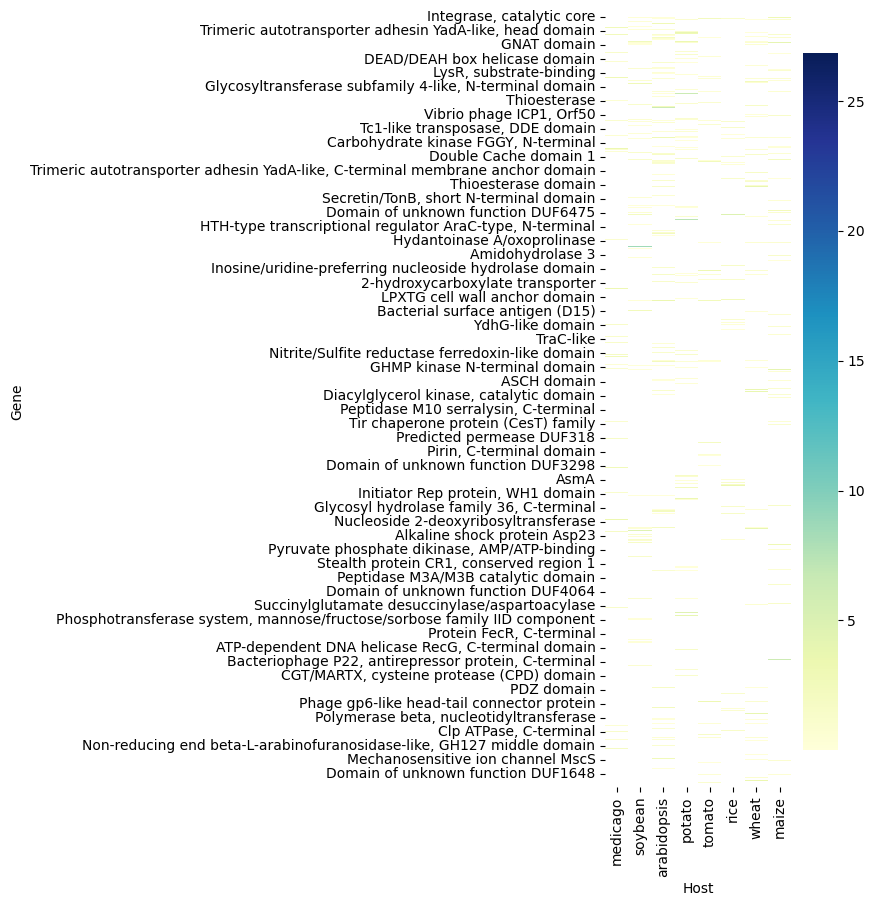

In [19]:

oiforheat = oi

oiforheat["ner"] = oiforheat.ner.str.replace("maize plants","maize").replace("zea mays","maize")
oiforheat["ner"] = oiforheat.ner.str.replace("arabidopsis thaliana","arabidopsis")
oiforheat["ner"] = oiforheat.ner.str.replace("triticum","wheat")
# Remove non-informative ners and merge duplicated
to_filter_out = ["sugar","legume","lotus"]# "cattle","mouse","sugarcane"]
filtered_oi = oiforheat[~oiforheat['ner'].isin(to_filter_out)]

genes_occurrence = filtered_oi['gene'].value_counts()
genes_several = genes_occurrence[genes_occurrence > 3].index.tolist()
filtered_oi = filtered_oi[filtered_oi['gene'].isin(genes_several)]

# Pivot the dataframe to create a matrix for the heatmap
heatmap_data = filtered_oi.pivot_table(index='ner', columns='gene', values='importance_values', aggfunc='max')

# order_ner = ["cattle","sheep","mouse","sugarcane","maize","wheat","rice","tobacco","tomato","potato","arabidopsis","soybean","phaseolus","medicago"]
order_ner = ["maize","wheat","rice","tomato","potato","arabidopsis","soybean","medicago"]
order_ner.reverse()
order_genes = [a for a in genes_occurrence.index.to_list() if a in heatmap_data.columns.to_list()]

heatmap_data = heatmap_data.loc[order_ner,order_genes]
# Create the heatmap
plt.figure(figsize=(3, 10))
sns.heatmap(heatmap_data.T, cmap='YlGnBu', annot=False, fmt=".2f", cbar=True, )

#plt.title('Importance Values Heatmap')
plt.xlabel('Host')
plt.ylabel('Gene')
plt.savefig("figures/xgboost/xgboost_heatmap.pdf",bbox_inches="tight")


#### Check for evolution on these genes

In [20]:
genes_to_check = heatmap_data.T.index

### Phenotypic traits

---

In [23]:
df

,rel,ner,gene,importance_values,importance_ranking,accuracy
0,STRAIN-ORGANISM:SYMBIONT_OF,soybean,Ribosomal RNA adenine methyltransferase KsgA/Erm,7.194476,1.0,0.909091
1,STRAIN-ORGANISM:SYMBIONT_OF,soybean,OST-HTH/LOTUS domain,5.896133,2.0,0.909091
2,STRAIN-ORGANISM:SYMBIONT_OF,soybean,GroES chaperonin family,4.183388,3.0,0.909091
3,STRAIN-ORGANISM:SYMBIONT_OF,soybean,"Transposase IS204/IS1001/IS1096/IS1165, zinc-f...",3.442744,4.0,0.909091
4,STRAIN-ORGANISM:SYMBIONT_OF,soybean,Ureohydrolase,3.343748,5.0,0.909091
...,...,...,...,...,...,...
566825,STRAIN-MEDIUM:GROWS_ON,glycerol-dextrose agar,Amidase signature domain,0.845424,19.0,0.999839
566826,STRAIN-MEDIUM:GROWS_ON,glycerol-dextrose agar,NUDIX hydrolase domain,0.802909,20.0,0.999839
566827,STRAIN-MEDIUM:GROWS_ON,glycerol-dextrose agar,Outer membrane efflux protein,0.721978,21.0,0.999839
566828,STRAIN-MEDIUM:GROWS_ON,glycerol-dextrose agar,"ABC-three component systems, C-terminal domain 10",0.700831,22.0,0.999839


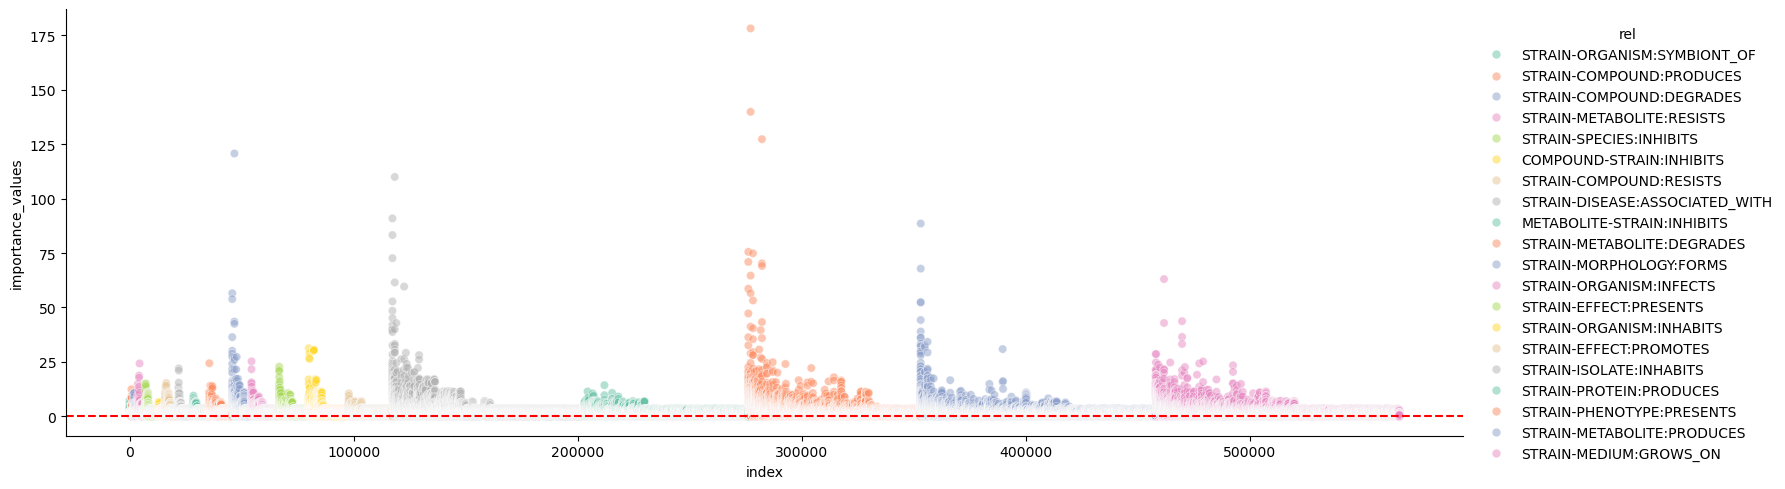

In [41]:
sns.relplot(y="importance_values", x="index", hue="rel", data=df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

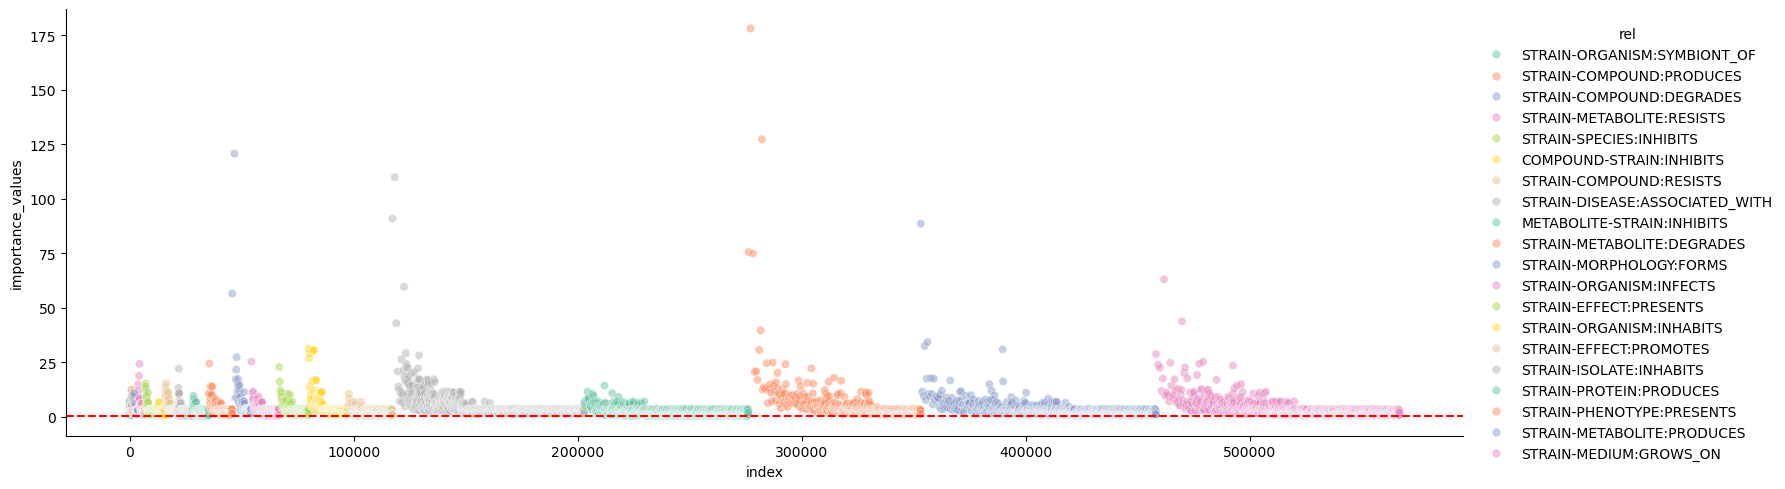

In [24]:
sns.relplot(y="importance_values", x="index", hue="rel", data=df[df["importance_ranking"]==1].reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

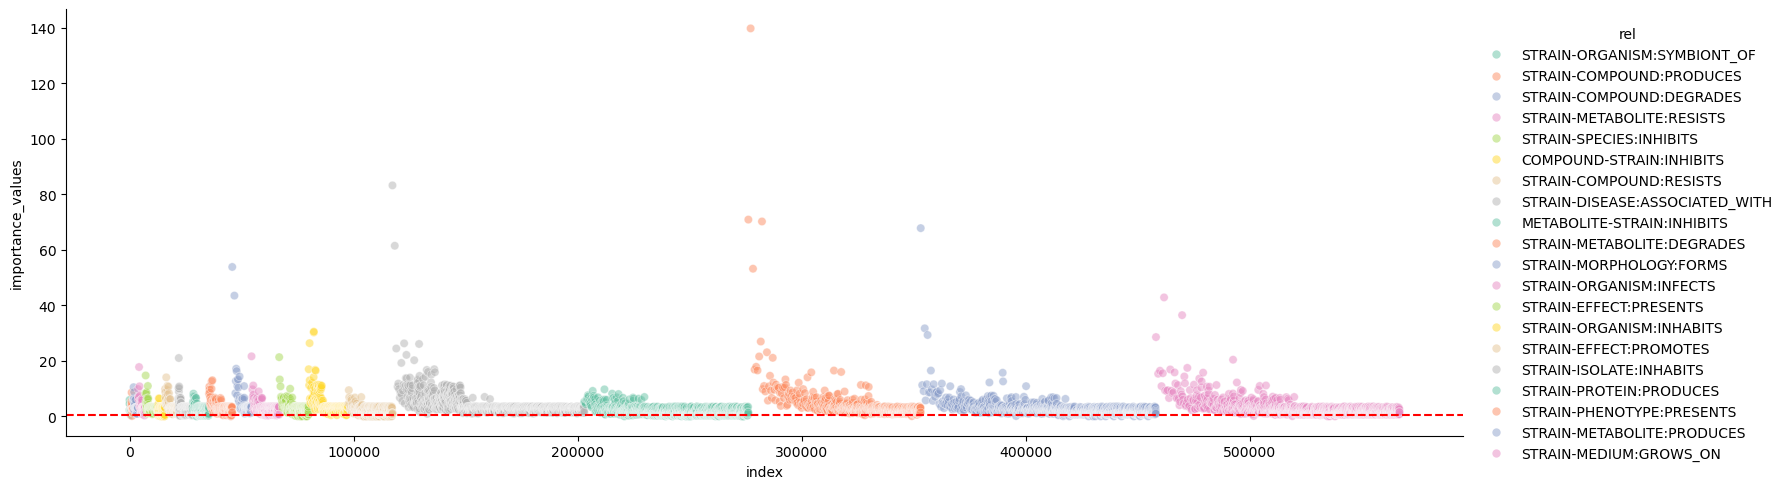

In [25]:
sns.relplot(y="importance_values", x="index", hue="rel", data=df[df["importance_ranking"]==2].reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.37, color='r', linestyle='--')

add value counts and check whether these play a role in the value significance. if it does, we could consider normalizing by this value

In [26]:
df

,rel,ner,gene,importance_values,importance_ranking,accuracy
0,STRAIN-ORGANISM:SYMBIONT_OF,soybean,Ribosomal RNA adenine methyltransferase KsgA/Erm,7.194476,1.0,0.909091
1,STRAIN-ORGANISM:SYMBIONT_OF,soybean,OST-HTH/LOTUS domain,5.896133,2.0,0.909091
2,STRAIN-ORGANISM:SYMBIONT_OF,soybean,GroES chaperonin family,4.183388,3.0,0.909091
3,STRAIN-ORGANISM:SYMBIONT_OF,soybean,"Transposase IS204/IS1001/IS1096/IS1165, zinc-f...",3.442744,4.0,0.909091
4,STRAIN-ORGANISM:SYMBIONT_OF,soybean,Ureohydrolase,3.343748,5.0,0.909091
...,...,...,...,...,...,...
566825,STRAIN-MEDIUM:GROWS_ON,glycerol-dextrose agar,Amidase signature domain,0.845424,19.0,0.999839
566826,STRAIN-MEDIUM:GROWS_ON,glycerol-dextrose agar,NUDIX hydrolase domain,0.802909,20.0,0.999839
566827,STRAIN-MEDIUM:GROWS_ON,glycerol-dextrose agar,Outer membrane efflux protein,0.721978,21.0,0.999839
566828,STRAIN-MEDIUM:GROWS_ON,glycerol-dextrose agar,"ABC-three component systems, C-terminal domain 10",0.700831,22.0,0.999839


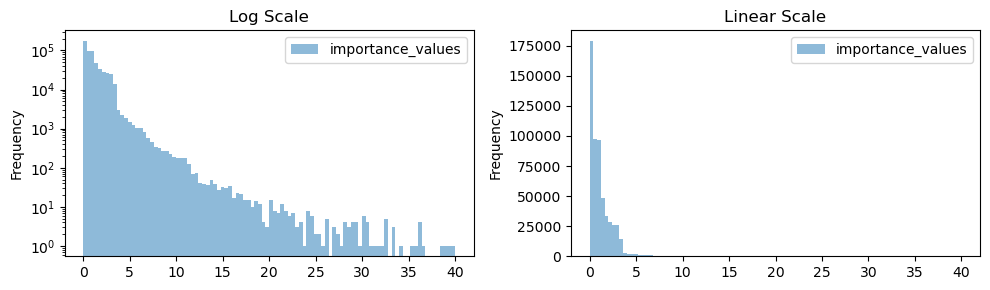

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
df.plot(kind='hist',y="importance_values",bins=100,range=(0,40),alpha=0.5, ax=ax[0])
df.plot(kind='hist',y="importance_values",bins=100,range=(0,40),alpha=0.5, ax=ax[1])
ax[0].set_yscale("log")
ax[0].set_title('Log Scale')
ax[1].set_title('Linear Scale')
plt.tight_layout()


#### Group by function

In [36]:
df.value_counts("gene")

gene
Transposase IS4-like domain                                    1572
Integrase, catalytic core                                      1504
HTH-like domain                                                1360
Transposase IS3/IS911family                                    1198
Insertion element IS1 protein InsA, helix-turn-helix domain    1034
                                                               ... 
Protein of unknown function DUF1464                               1
Protein of unknown function DUF1480                               1
Fimbrium tip subunit Fim1C-like, C-terminal domain                1
Protein of unknown function DUF3926                               1
Domain of unknown function DUF5114                                1
Name: count, Length: 10834, dtype: int64

In [38]:
df[df["gene"]=="Transposase IS4-like domain"]

,rel,ner,gene,importance_values,importance_ranking,accuracy
374,STRAIN-ORGANISM:SYMBIONT_OF,aphids,Transposase IS4-like domain,1.123388,28.0,0.969697
881,STRAIN-COMPOUND:PRODUCES,co,Transposase IS4-like domain,1.140186,4.0,0.827586
3924,STRAIN-METABOLITE:RESISTS,streptomycin,Transposase IS4-like domain,0.055166,148.0,0.913208
4102,STRAIN-METABOLITE:RESISTS,rifampicin,Transposase IS4-like domain,0.392212,60.0,0.947170
4756,STRAIN-METABOLITE:RESISTS,ciprofloxacin,Transposase IS4-like domain,0.659803,32.0,0.973585
...,...,...,...,...,...,...
564484,STRAIN-MEDIUM:GROWS_ON,glutathione sepharose,Transposase IS4-like domain,0.047518,10.0,0.999839
564896,STRAIN-MEDIUM:GROWS_ON,v,Transposase IS4-like domain,0.928769,30.0,0.999839
565556,STRAIN-MEDIUM:GROWS_ON,iron,Transposase IS4-like domain,0.004684,12.0,0.999839
566795,STRAIN-MEDIUM:GROWS_ON,glycerol-,Transposase IS4-like domain,0.005374,26.0,0.999839


#### Calculate number of assemblies per NER

TODO: Calculate also species per NER?

In [39]:
assemblies_perner = []
for rel in tqdm(rels):
	d[rel]= []
	filepath = f"/home/gomez/gomez/xgboost/annotations{data}_{max_assembly}/{rel}.pkl"
	# Read the pickle file
	with open(filepath, "rb") as f:
		dat = pickle.load(f)
	vc = pd.DataFrame(pd.DataFrame(dat[1]).value_counts())
	vc["rel"] = rel
	assemblies_perner.append(vc)
	

  0%|          | 0/20 [00:00<?, ?it/s]

In [42]:
assemblies = pd.concat(assemblies_perner)

In [43]:
merged_df = df.merge(assemblies,left_on=["rel","ner"],right_on=["rel",0])

In [45]:
merged_df.sort_values("count")

,rel,ner,gene,importance_values,importance_ranking,accuracy,count
566829,STRAIN-MEDIUM:GROWS_ON,glycerol-dextrose agar,"Intradiol ring-cleavage dioxygenase, C-terminal",0.507875,23.0,0.999839,3
237017,STRAIN-PROTEIN:PRODUCES,ospc,Glycine zipper domain,0.001763,24.0,0.999739,3
237018,STRAIN-PROTEIN:PRODUCES,ospc,"Transposase, IS1",0.001373,25.0,0.999739,3
237019,STRAIN-PROTEIN:PRODUCES,ospc,"Cold-shock protein, DNA-binding",0.000773,26.0,0.999739,3
237020,STRAIN-PROTEIN:PRODUCES,osdlk,"Bacteriophage lambda, Tail fiber protein, repe...",0.482991,1.0,0.999739,3
...,...,...,...,...,...,...,...
46478,STRAIN-MORPHOLOGY:FORMS,biofilm,RmlD-like substrate binding domain,2.009746,635.0,0.810644,774
46477,STRAIN-MORPHOLOGY:FORMS,biofilm,"Pirin, N-terminal domain",2.017292,634.0,0.810644,774
46476,STRAIN-MORPHOLOGY:FORMS,biofilm,Dimethlysulfonioproprionate lyase,2.022492,633.0,0.810644,774
46324,STRAIN-MORPHOLOGY:FORMS,biofilm,Protein of unknown function DUF350,2.755839,481.0,0.810644,774


/tmp/ipykernel_90974/963669256.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.relplot(y="importance_values", x="count", col="rel", data=merged_df,aspect=2, height=2, palette="Set2",col_wrap=5, alpha=.5)


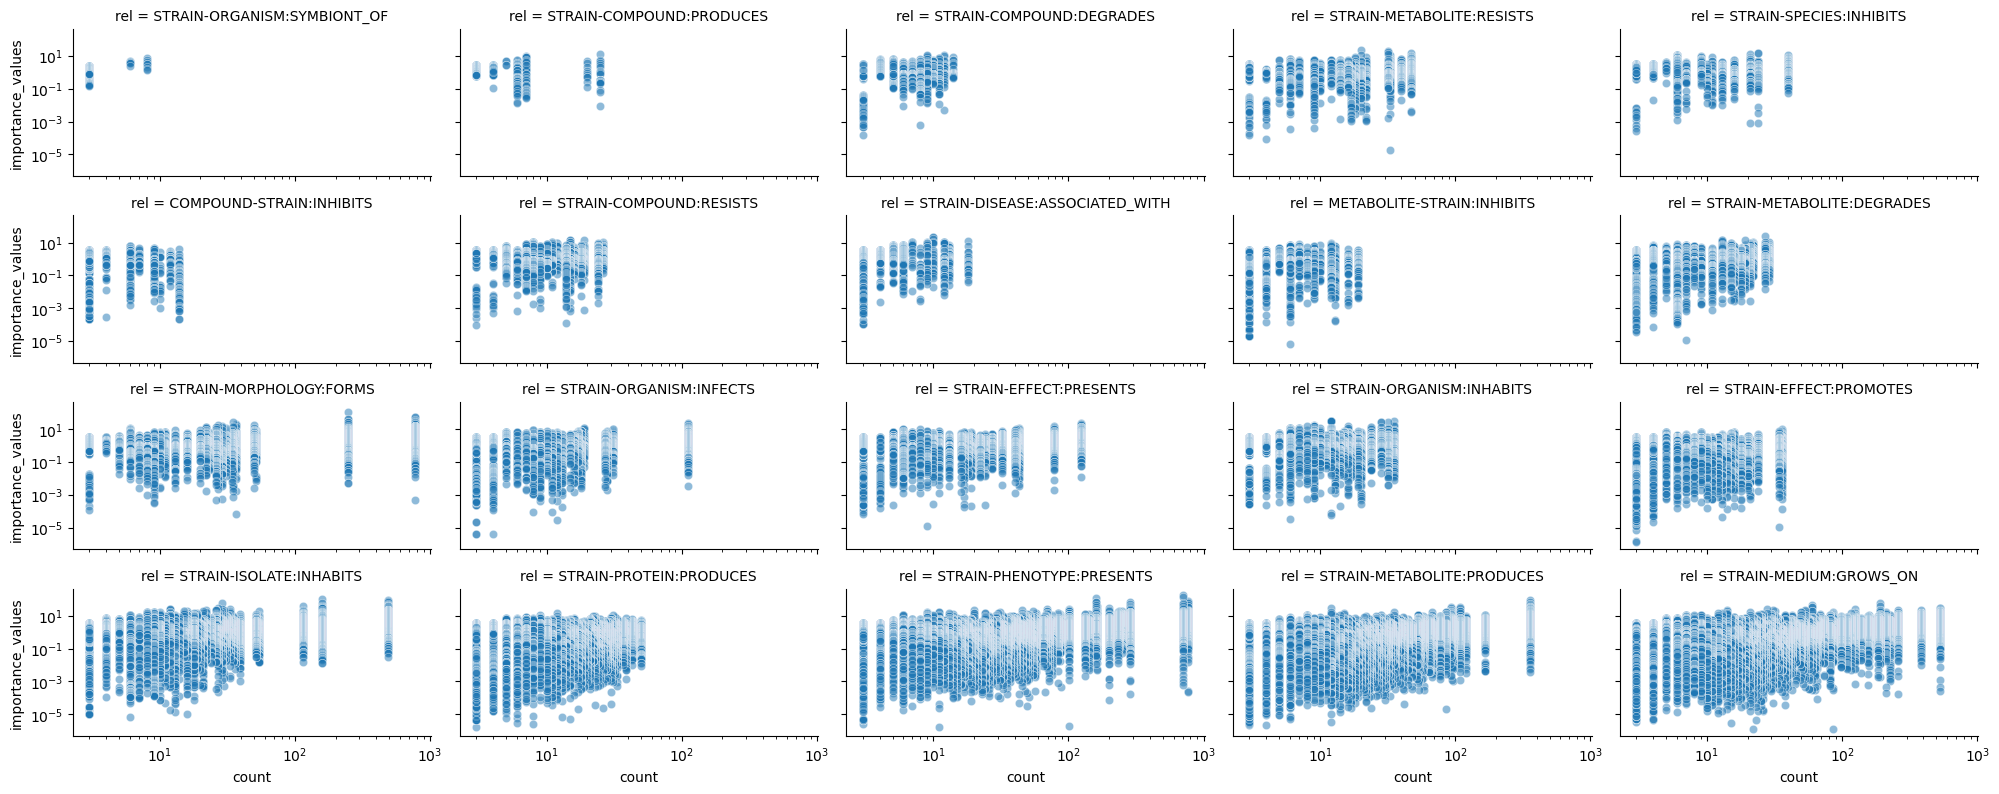

In [47]:
sns.relplot(y="importance_values", x="count", col="rel", data=merged_df,aspect=2, height=2, palette="Set2",col_wrap=5, alpha=.5)
plt.xscale("log")
plt.yscale("log")

#### Try to normalize by the number of assemblies per NER

In [49]:
merged_df['normalized_value'] = (merged_df['importance_values'] / merged_df['count'])

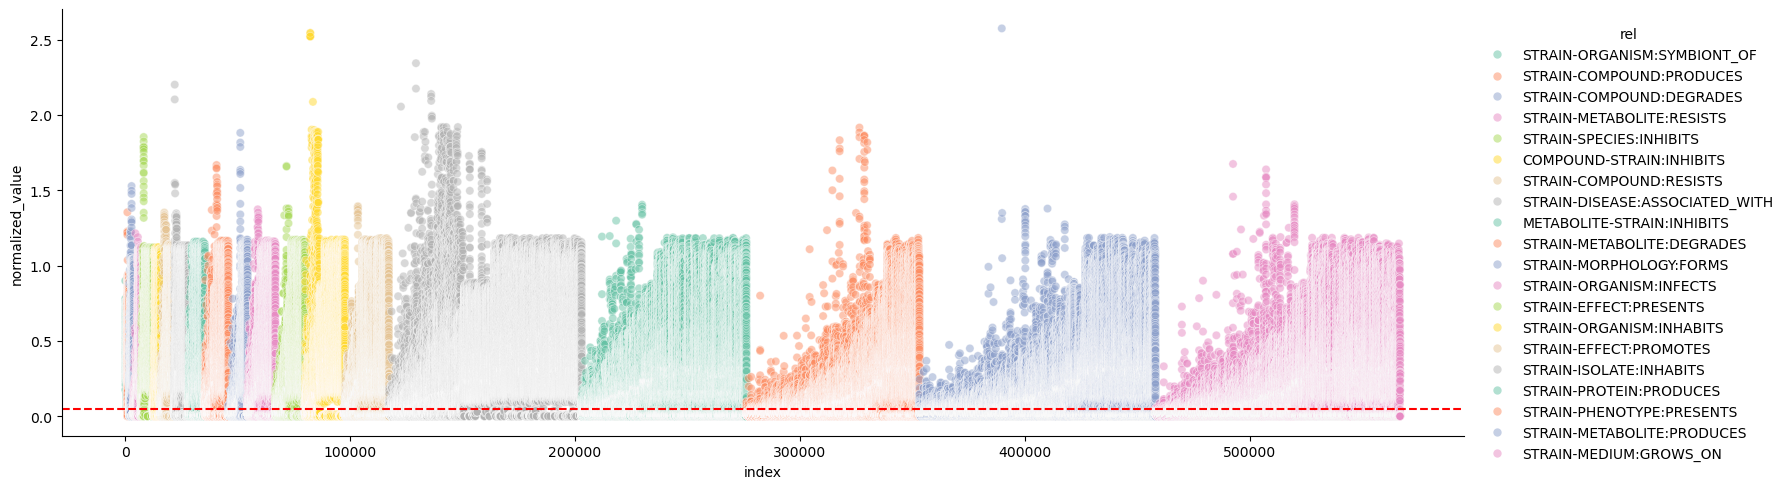

In [50]:
sns.relplot(y="normalized_value", x="index", hue="rel", data=merged_df.reset_index(),aspect=3, alpha = 0.5, palette="Set2")

plt.axhline(y=0.05, color='r', linestyle='--')

In [51]:
merged_df.sort_values("normalized_value")

,rel,ner,gene,importance_values,importance_ranking,accuracy,count,normalized_value
466820,STRAIN-MEDIUM:GROWS_ON,mrs broth,Translational (tr)-type GTP-binding domain,0.000001,368.0,0.994526,86,1.396442e-08
284953,STRAIN-PHENOTYPE:PRESENTS,nitrogen-fixing,"Sulphur relay, TusB/DsrH",0.000002,457.0,0.989985,101,1.895841e-08
484805,STRAIN-MEDIUM:GROWS_ON,nutrient,6-carboxyhexanoate--CoA ligase,0.000001,180.0,0.998390,22,5.436331e-08
314587,STRAIN-PHENOTYPE:PRESENTS,methane-oxidizing,PAS fold-4,0.000002,58.0,0.999148,11,1.527369e-07
492235,STRAIN-MEDIUM:GROWS_ON,king's medium b,"DNA binding HTH domain, AraC-type",0.000003,144.0,0.998551,15,1.874597e-07
...,...,...,...,...,...,...,...,...
82165,STRAIN-ORGANISM:INHABITS,soybean plant,"Transposase TnpC, homeodomain",30.249023,1.0,0.997567,12,2.520752e+00
82245,STRAIN-ORGANISM:INHABITS,casuarina,Pterin 4 alpha carbinolamine dehydratase,30.249023,1.0,0.996350,12,2.520752e+00
82251,STRAIN-ORGANISM:INHABITS,p. larvae,ADP ribosyltransferase,30.517075,2.0,1.000000,12,2.543090e+00
82250,STRAIN-ORGANISM:INHABITS,p. larvae,"L-tyrosine decarboxylase, C-terminal",30.530426,1.0,1.000000,12,2.544202e+00


#### Find features where top three are very close

## Evolution

### Example (do not run)

In [57]:
merged_df.iloc[485]

rel                                  STRAIN-PHENOTYPE:PRESENTS
ner                                     plant growth-promoting
first_value                                           2.934033
first_gene                             Pyocin S killer protein
second_value                                          2.929163
second_gene                      Ribosome-inactivating protein
third_value                                           2.928898
third_gene                 Protein of unknown function DUF3275
count                                                       10
normalized_value                                      0.293403
first_second_difference                               0.004871
first_third_difference                                0.005135
Name: 485, dtype: object

In [58]:
parq = pd.read_parquet(f"/home/gomez/gomez/xgboost/annotations810_7/{merged_df.iloc[485].rel}.parquet")

In [59]:
strains = parq[parq["word_qc"]==merged_df.iloc[485].ner].sa_ner.str.split("_",expand=True)[0].unique()

In [60]:
protein_ids = parq[parq["InterPro_description"]== merged_df.iloc[485].first_gene].Protein_accession.unique()

In [61]:

output_faa = []
for s in strains:
	strain = s.replace(" ","_")
	# Check if the folder exists
	folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
	if os.path.exists(folder_path):
		for assembly in os.listdir(folder_path):
			faa_files = glob(f"{folder_path}/{assembly}/*.faa")
			if faa_files:
				faa_file = faa_files[0]
				for record in SeqIO.parse(faa_file, "fasta"):
					if record.id in protein_ids:
						output_faa.append(record)

with open("test.faa","w") as f:
	SeqIO.write(output_faa, f, "fasta")

In [64]:
output_fna = []
for s in strains:
	strain = s.replace(" ","_")
	folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
	if os.path.exists(folder_path):
		for assembly in os.listdir(folder_path):
			fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
			if fna_files:
				fna_file = fna_files[0]
				for record in SeqIO.parse(fna_file, "fasta"):
					if record.id in protein_ids:
						output_fna.append(record)
with open("test.fna","w") as f:
	SeqIO.write(output_fna, f, "fasta")

### Run for all rows in merged_df and save files into a folder each

In [28]:
outdir = f"/home/gomez/gomez/seqfiles_linkbert_{data}_{max_assembly}"
os.makedirs(outdir,exist_ok=True)
for rel in tqdm(merged_df['rel'].unique()):
	filtered_df = merged_df[merged_df['rel'] == rel]
	parq = pd.read_parquet(f"/home/gomez/gomez/xgboost/annotations810_7/{rel}.parquet")
	for row in tqdm(filtered_df.iterrows(), total=len(filtered_df), leave=False):
		sa_ner = parq[parq["word_qc"]==row[1]['ner']].sa_ner
		if not sa_ner.empty:  # Use .empty to check if the Series is empty
			strains = sa_ner.str.split("_",expand=True)[0].unique()
			new_rel = row[1]['rel'].replace(':','_')
			new_ner = row[1]['ner'].replace(' ','_').replace("'",'').replace('(','_').replace(')','_')
			sa_ner = f"first_{new_rel}_{new_ner}"
			protein_ids = parq[parq["InterPro_description"]== row[1]['first_gene']].Protein_accession.unique()
			output_faa = []
			output_fna = []
			for s in strains:
				strain = s.replace(" ","_")
				folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
				if os.path.exists(folder_path):
					for assembly in os.listdir(folder_path):
						faa_files = glob(f"{folder_path}/{assembly}/*.faa")
						fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
						if faa_files:
							faa_file = faa_files[0]
							for record in SeqIO.parse(faa_file, "fasta"):
								if record.id in protein_ids:
									record.description = ""
									output_faa.append(record)
						if fna_files:
							fna_file = fna_files[0]
							for record in SeqIO.parse(fna_file, "fasta"):
								if record.id in protein_ids:
									output_fna.append(record)
			os.makedirs(f"{outdir}/{sa_ner}",exist_ok=True)
			with open(f"{outdir}/{sa_ner}/seq.faa","w") as f:
				SeqIO.write(output_faa, f, "fasta")
			with open(f"{outdir}/{sa_ner}/seq.fna","w") as f:
				SeqIO.write(output_fna, f, "fasta")

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

### Create test set

In [29]:
# outdir = f"/home/gomez/gomez/seqfiles_linkbert_{data}_{max_assembly}"
# os.makedirs(outdir,exist_ok=True)
for rel in tqdm(merged_df['rel'].unique()):
	filtered_df = merged_df[merged_df['rel'] == rel]
	parq = pd.read_parquet(f"/home/gomez/gomez/xgboost/annotations810_7/{rel}.parquet")
	for row in tqdm(filtered_df.iterrows(), total=len(filtered_df), leave=False):
		sa_ner = parq[parq["word_qc"]==row[1]['ner']].sa_ner
		if not sa_ner.empty:  # Use .empty to check if the Series is empty
			strains = sa_ner.str.split("_",expand=True)[0].unique()
			new_rel = row[1]['rel'].replace(':','_')
			new_ner = row[1]['ner'].replace(' ','_').replace("'",'').replace('(','_').replace(')','_')
			sa_ner = f"last_{new_rel}_{new_ner}"
			protein_ids = parq[parq["InterPro_description"]== row[1]['last_gene']].Protein_accession.unique()
			output_faa = []
			output_fna = []
			for s in strains:
				strain = s.replace(" ","_")
				folder_path = f"/home/gomez/gomez/assemblies_linkbert_5/{strain}"
				if os.path.exists(folder_path):
					for assembly in os.listdir(folder_path):
						faa_files = glob(f"{folder_path}/{assembly}/*.faa")
						fna_files = glob(f"{folder_path}/{assembly}/*.fasta")
						if faa_files:
							faa_file = faa_files[0]
							for record in SeqIO.parse(faa_file, "fasta"):
								if record.id in protein_ids:
									record.description = ""
									output_faa.append(record)
						if fna_files:
							fna_file = fna_files[0]
							for record in SeqIO.parse(fna_file, "fasta"):
								if record.id in protein_ids:
									output_fna.append(record)
			os.makedirs(f"{outdir}/{sa_ner}",exist_ok=True)
			with open(f"{outdir}/{sa_ner}/seq.faa","w") as f:
				SeqIO.write(output_faa, f, "fasta")
			with open(f"{outdir}/{sa_ner}/seq.fna","w") as f:
				SeqIO.write(output_fna, f, "fasta")

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/273 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/161 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

In [30]:

# Set the directory where the files are located
directory = "/home/gomez/gomez/seqfiles_linkbert_810_5"

# Iterate over all files in the directory
for root, dirs, files in tqdm(os.walk(directory)):
    for file in files:
        # Check if the file is a fasta file
        if file.endswith(".faa") or file.endswith(".fna"):
            # Get the full path of the file
            file_path = os.path.join(root, file)
            
            # Create a temporary file to store the deduplicated sequences
            temp_file = file_path + ".temp"
            
            # Run seqkit rmdup command to delete duplicate sequences
            os.system(f"seqkit rmdup -n -o {temp_file} {file_path}")
            
            # Replace the original file with the deduplicated file
            os.replace(temp_file, file_path)


0it [00:00, ?it/s]

[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records removed
[INFO] 0 duplicated records 